# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [55]:
# Imports
import category_encoders as ce
import numpy as np
import pandas as pd
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from pdpbox.pdp import pdp_isolate, pdp_plot
import shap

In [3]:
train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

In [9]:
# Part 1: Preprocessing
print("Train dtypes:\n", train.dtypes, '\n\nTest dtypes:\n', test.dtypes)

Train dtypes:
 Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
dtype: object 

Test dtypes:
 Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
dtype: object


In [10]:
train.sample(9)

Inspection ID                        DBA Name  \
30151        1975646                            OYSY   
26330        1493284                 RANDOLPH TAVERN   
35419        1496907  GATEWAY TO LEARNING SPECIAL ED   
17478        2145540                  GINA'S CHICKEN   
22297        1365224                      L'APPETITO   
27458         409537                   AMERICA'S DOG   
46765        2104840         SYMPHONY OF MORGAN PARK   
36793        1494027                 PIERRE'S BAKERY   
37235        1632157                        RED DOOR   

                         AKA Name  License #   Facility Type             Risk  \
30151                        OYSY  1573096.0      Restaurant    Risk 1 (High)   
26330             RANDOLPH TAVERN  2283318.0      Restaurant    Risk 1 (High)   
35419       DOROTHY'S CAN DO CAFE  2146528.0      Restaurant  Risk 2 (Medium)   
17478              GINA'S CHICKEN    37407.0      Restaurant    Risk 1 (High)   
22297                  L'APPETITO    42672.0      Restaurant    Risk 1 (High)   
27458               AMERICA'S DOG  1903311.0      Restaurant    Risk 1 (High)   
46765  THE RENAISSANCE PARK SOUTH  2447175.0  Long Term Care    Risk 1 (High)   
36793             PIERRE'S BAKERY  2108013.0      Restaurant  Risk 2 (Medium)   
37235                    RED DOOR  1249926.0      Restaurant    Risk 1 (High)   

                   Address     City State      Zip      Inspection Date  \
30151      50 E GRAND AVE   CHICAGO    IL  60611.0  2016-11-17T00:00:00   
26330   188 W RANDOLPH ST   CHICAGO    IL  60601.0  2014-08-05T00:00:00   
35419  4925 N LINCOLN AVE   CHICAGO    IL  60625.0  2014-09-19T00:00:00   
17478     3415 E 106TH ST   CHICAGO    IL  60617.0  2018-02-26T00:00:00   
22297  875 N MICHIGAN AVE   CHICAGO    IL  60611.0  2013-08-06T00:00:00   
27458       21 E ADAMS ST   CHICAGO    IL  60603.0  2011-01-24T00:00:00   
46765  10935 S HALSTED ST   CHICAGO    IL  60628.0  2017-11-16T00:00:00   
36793  1956 W CHICAGO AVE   CHICAGO    IL  60622.0  2014-08-26T00:00:00   
37235    2118 N DAMEN AVE   CHICAGO    IL  60647.0  2016-02-23T00:00:00   

               Inspection Type  \
30151  Complaint Re-Inspection   
26330     Short Form Complaint   
35419                  Canvass   
17478                  Canvass   
22297                  Canvass   
27458                  Canvass   
46765                  License   
36793                  Canvass   
37235    Canvass Re-Inspection   

                                              Violations   Latitude  \
30151  38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...  41.891805   
26330  35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...  41.884580   
35419  33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...  41.971466   
17478  35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...  41.702646   
22297  38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...  41.898949   
27458  32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...  41.879390   
46765  3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...  41.694949   
36793  30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...  41.896024   
37235  30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...  41.920076   

       Longitude                                           Location  Fail  
30151 -87.626089  {'longitude': '-87.6260893784433', 'latitude':...     0  
26330 -87.633757  {'longitude': '-87.63375683353853', 'latitude'...     0  
35419 -87.690215  {'longitude': '-87.69021462743629', 'latitude'...     0  
17478 -87.540678  {'longitude': '-87.54067794104229', 'latitude'...     0  
22297 -87.623975  {'longitude': '-87.62397498768968', 'latitude'...     0  
27458 -87.626920  {'longitude': '-87.6269200545445', 'latitude':...     0  
46765 -87.642313  {'longitude': '-87.64231340979583', 'latitude'...     1  
36793 -87.676911  {'longitude': '-87.67691073456803', 'latitude'...     0  
37235 -87.677852  {'longitude': '-87.67785212775735', 'latitude'...     0

In [11]:
# What percentage fail?
train["Fail"].value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

In [36]:
# Drop useless columns
df_train = train.drop(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Address',
        'State', 'Longitude', 'Latitude', 'Location', 'Inspection Date'], axis=1)
df_test = test.drop(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Address',
        'State', 'Longitude', 'Latitude', 'Location', 'Inspection Date'], axis=1)

In [37]:
df_train.sample(9)

Facility Type             Risk     City      Zip  \
34229     Restaurant    Risk 1 (High)  CHICAGO  60643.0   
24662  Special Event     Risk 3 (Low)  CHICAGO  60644.0   
44658     Restaurant  Risk 2 (Medium)  CHICAGO  60659.0   
41682  Grocery Store     Risk 3 (Low)  CHICAGO  60628.0   
36805         School    Risk 1 (High)  CHICAGO  60659.0   
15779     Restaurant    Risk 1 (High)  CHICAGO  60654.0   
27771         School    Risk 1 (High)  CHICAGO  60624.0   
45715         School  Risk 2 (Medium)  CHICAGO  60615.0   
49677     Restaurant    Risk 1 (High)  CHICAGO  60632.0   

             Inspection Type  \
34229                Canvass   
24662  License Re-Inspection   
44658                Canvass   
41682                Canvass   
36805                Canvass   
15779  Canvass Re-Inspection   
27771                Canvass   
45715                Canvass   
49677                Canvass   

                                              Violations  Fail  
34229  34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...     0  
24662                                                NaN     0  
44658  32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...     0  
41682  32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...     0  
36805  41. PREMISES MAINTAINED FREE OF LITTER, UNNECE...     0  
15779  16. FOOD PROTECTED DURING STORAGE, PREPARATION...     1  
27771  34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...     0  
45715  26. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, P...     1  
49677  33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...     0

In [38]:
# replace Violations with a count of the total number of violations & set NaNs to 0
for df in [df_train, df_test]:
    df['Violations'] = df['Violations'].astype(str).str.count('\|') + 1
    df['Violations'] = df['Violations'].fillna(0)

In [39]:
df_train.sample(9)

Facility Type             Risk     City      Zip  \
33268           butcher shop  Risk 2 (Medium)  CHICAGO  60607.0   
12610         Shared Kitchen    Risk 1 (High)  CHICAGO  60612.0   
27619           Golden Diner    Risk 1 (High)  CHICAGO  60610.0   
10044             Restaurant    Risk 1 (High)  CHICAGO  60616.0   
36363  Daycare (2 - 6 Years)    Risk 1 (High)  CHICAGO  60619.0   
32603          Grocery Store    Risk 1 (High)  CHICAGO  60620.0   
34516             Restaurant    Risk 1 (High)  CHICAGO  60609.0   
47252             Restaurant    Risk 1 (High)  CHICAGO  60643.0   
49392          Grocery Store    Risk 1 (High)  CHICAGO  60639.0   

               Inspection Type  Violations  Fail  
33268                  Canvass           3     0  
12610                  Canvass           1     0  
27619                  Canvass           2     0  
10044                  Canvass           3     0  
36363                  License           4     0  
32603                Complaint           4     0  
34516                Complaint           6     1  
47252                  Canvass           5     0  
49392  Complaint Re-Inspection           1     0

In [40]:
# encode most of the rest of the columns
cat_enc = ce.OrdinalEncoder(cols=['Facility Type', 'Risk', 'City', 'Inspection Type'])
# cat_enc = ce.OrdinalEncoder(cols=['Facility Type', 'Risk', 'City', 'Inspection Type', 'Violations'])

df_train = cat_enc.fit_transform(df_train)
df_test = cat_enc.transform(df_test)

In [41]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [42]:
# 'Fail' is target
X_train = df_train.drop('Fail', axis=1)
y_train = df_train['Fail']
X_test = df_test.drop('Fail', axis=1)
y_test = df_test['Fail']

In [50]:
%%time
# Part 2: Modeling
xgb = XGBClassifier(scale_pos_weight=1,
        learning_rate=0.02,
        objective='binary:logistic',
        n_estimators=1000,
        max_depth=6,
        colsample_bytree = 0.3,
        subsample = 0.8,
        gamma=1,
        nthread = -1,
        random_state = 42)

xgb.fit(X_train, y_train)
y_test_proba = xgb.predict_proba(X_test)[:,1]

print('Test ROC AUC:', roc_auc_score(y_test, y_test_proba))

Test ROC AUC: 0.8316868606980399
CPU times: user 56.4 s, sys: 3.54 s, total: 60 s
Wall time: 26 s


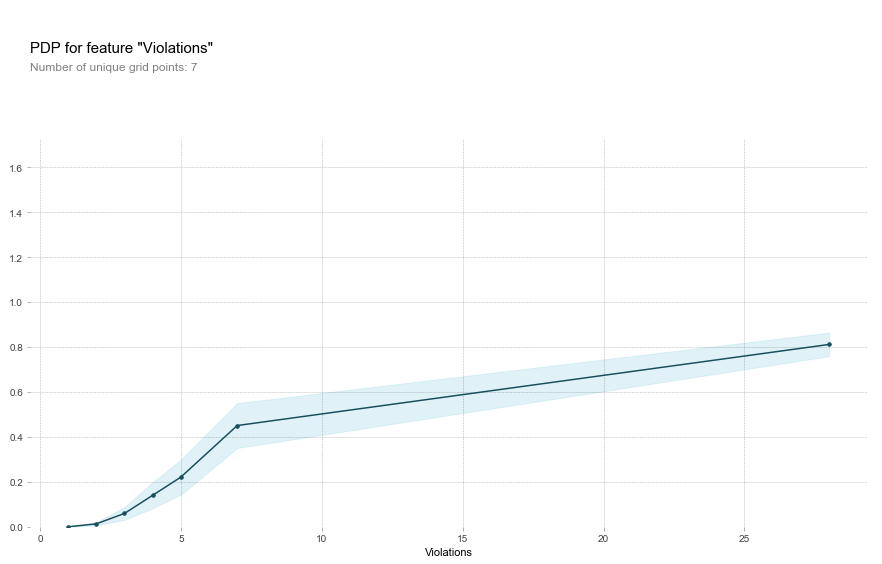

In [54]:
# Part 3: Visualization
# Graph Violations
pdp = pdp_isolate(model=xgb, dataset=X_train, model_features=X_train.columns, feature='Violations')
pdp_plot(pdp, 'Violations');

In [56]:
# As count of violations goes up, so does likelihood of failing. What a shocker!

In [58]:
# shap
shap_explainer = shap.TreeExplainer(xgb)
# Calculate values
shap_test_values = shap_explainer.shap_values(X_test)
# Plot Shap values
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_test_values, X_test)